# **IMDB 50k reviews Sentiment Analysis**


---
![](https://drive.google.com/uc?export=view&id=1n1dvbSUHJwF2GONfvKIiK7ulTkl2eqTE)

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.
For more dataset information, please go through the following link,
http://ai.stanford.edu/~amaas/data/sentiment/


---

### 1. Preparing libraries, loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install nlp

In [ ]:
! pip install emot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import spacy
from spacy.lang.en import English
spacy_english = spacy.load('en')
# spacy_english = English()
import nlp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import spacy
en_model = spacy.load('en')
nlpml = spacy.load('en_core_web_sm')
import string
PUNCTS = set(punct for punct in string.punctuation)
STOP_WORDS = set(stopwords.words("english"))
from collections import Counter
from bs4 import BeautifulSoup
import re,string,unicodedata
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import casual_tokenize
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from sklearn.base import BaseEstimator
from textblob import TextBlob
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
df = pd.read_csv('drive/My Drive/IMDB Dataset.csv')
df.sample(3)

,review,sentiment
14883,"In a better civilization, this and many other ...",positive
31549,"i just saw this film, i first saw it when i wa...",positive
45280,Don't bother to check for logic. There is none...,negative


### 2. Target class balance

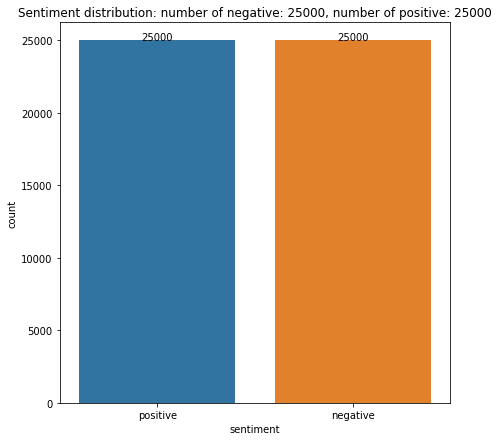

In [6]:
plt.figure(figsize=(7, 7))
labels = df.sentiment.value_counts().index
values = df.sentiment.value_counts().values
ax = sns.countplot(df.sentiment, label='Count')
negative, positive = df.sentiment.value_counts()
plt.title(f'Sentiment distribution: number of negative: {negative}, number of positive: {positive}')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1, values[i], ha='center')
plt.show();

### 3. Word Clouds for positive and negative reviews

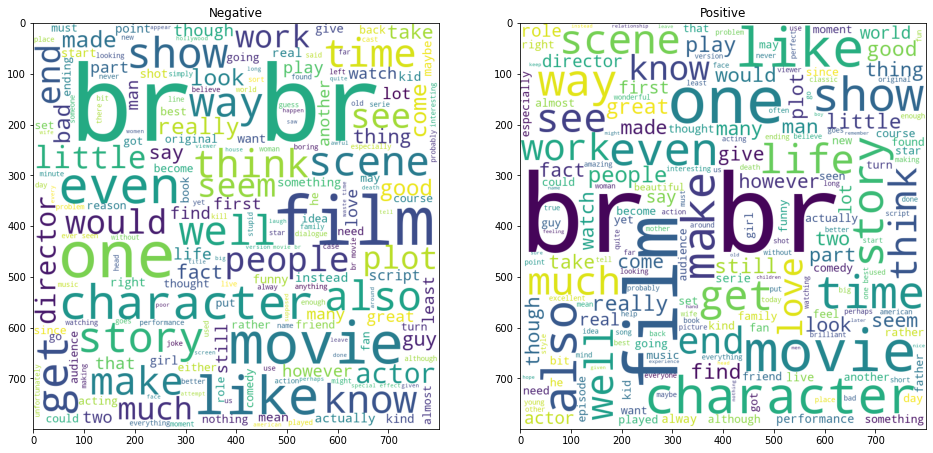

In [7]:
def wordcloud(all_words):
    """
    generates a wordcloud.
    Recevies a text to plot.
    """
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = STOP_WORDS, 
                    min_font_size = 10).generate(all_words) 
    return wordcloud

num_clusters = 2

_, axs = plt.subplots(1, 2, figsize=(16, 16))
axs = axs.flatten()

for k, ax in zip(range(num_clusters), axs):
    if k == 0:
        df_pn = df[df.sentiment == 'negative']
        title_pn = 'Negative'
    else:
        df_pn = df[df.sentiment == 'positive']
        title_pn = 'Positive'
    all_words = ' '.join([word.lower() for rev in df_pn.review for word in rev.split()])
    ax.imshow(wordcloud(all_words))
    ax.set_title(title_pn)
plt.show()

### 4. Taking a look on some random samples from the data
To have better understanding :)

In [8]:
negative_reviews, positive_reviews = df[df.sentiment == 'negative'], df[df.sentiment == 'positive']
number_of_samples = 3
print('Negative reviews:\n')
for i in range(number_of_samples):
    ind = np.random.choice(negative_reviews.index.tolist())
    sample_review = df.iloc[ind, 0]
    print(sample_review)
    print(f'~{len(sample_review.split())} words in the review')
    print()

print('\n\nPositive reviews:\n')
for i in range(number_of_samples):
    ind = np.random.choice(positive_reviews.index.tolist())
    sample_review = df.iloc[ind, 0]
    print(sample_review)
    print(f'~{len(sample_review.split())} words in the review')
    print()

Negative reviews:

For reasons I cannot begin to fathom, Dr. Lorenzo Cameron (George Zucco) begins injecting wolf's blood into his dim-witted handyman, Petro (Glenn Strange). The result  Petro is transformed into a hideous (as hideous as someone with a bad wig and pointy teeth can be) killer beast. Dr. Cameron uses Petro to get his revenge against those in the scientific community who scoffed at and ridiculed his ideas (and why wouldn't they, Dr. Cameron's nuttier than a fruitcake).<br /><br />Overall, The Mad Monster is one dull and poorly made Poverty Row thriller. There's really only one positive I can come up with to write about in The Mad Monster. George Zucco can be fun to watch as he plays the mad scientist about as well as anyone. His Dr. Cameron is a regular loony. He has no qualms about killing; he has entire conversations with people who aren't there; and, as with most mad scientists, he messes in "God's domain" (actually, I'm not sure anyone accuses him of this, but it fit

Some conclusions:



*   we have to remove constructions like '< br /> < br />'
*   deal somehow with examples like ' * * * out of * * * * '
*   consider the length of reviews: maybe ppl tend to explain their frustation about the movie in more words than satisfaction
*   do sth with slang like 'sth', 'gr8', etc



Let's add sentence length as a feature later, after preprocessing and cleaning the data.

### 5. Preparing the data: removing stopwords, punctuation, etc, tokenization, stem/lemmas

In [9]:
class TextPreprocessing:
    """
    Remove irrelevant characters, symbols, stopwords. Tokenization. Lemmatization/Stemmer
    """

    def __init__(self, data, text_column, occurance_thresh=1, max_length=1000000):
        self.text_column = text_column
        self.data = data
        self.occurance_thresh = occurance_thresh
        self.max_length = max_length

    def strip_html(self, text): 
        # added from kaggle
        """
        Removes things like <br>
        """
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    def tokenize(self, s):
        """
        Tokenization
        """
        return ' '.join(word_tokenize(s))

    def re_sub_text(self, s):
        """
        Removes irrelevant patterns in the text
        """
        s = s.lower()
        # added from kaggle :)
        s = re.sub('\[[^]]*\]', '', s)
        s = re.sub(r'http\S+', '', s)
        s = re.sub(r'\d+', ' ', s)

        # s = re.sub(r'\brt\b', ' ', s)
        # s = re.sub(r'#', ' ', s)
        # s = re.sub(r"xa0[\']*", ' ', s)
        # s = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)', " ", s)
        # s = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ', s)
        # s = re.sub(r'\s+[a-z]\s+', ' ', s)
        # s = re.sub(r'^[a-z]\s+', ' ', s)
        # s = re.sub(r'\s+', ' ', s)

        s = s.replace("n't", 'not')
        s = s.replace('gr8', 'great')
        s = s.replace('sh*t', 'shit')
        s = s.replace('f*ck', 'fuck') 
        s = s.replace("'s", ' ')
        s = s.replace("sth", 'something')
        s = s.replace("é", 'e')
        s = s.replace ('--', ' ')
        s = s.replace("''", " ")
        s = s.replace('...', ' ')
        s = s.replace('"s', ' ')
        s= s.replace('-', ' ')
        return s

    def correct_stopwords(self):
        """Returns a list of stopwords without some of the negative words"""
        stopwords_list = stopwords.words('english')
        stopwords_list.remove('not')
        stopwords_list.remove('no')
        stopwords_list.remove('nor')
        return stopwords_list    

    def lemmatize_lowerize_remove_stops(self, text):
        text = text.lower()
        text = ' '.join([tkn.lemma_.strip() for tkn in spacy_english(text) 
                        if tkn.text not in self.correct_stopwords()])
        return text

    def remove_punct(self, text):
        text = ' '.join([tkn for tkn in text.split() if tkn not in PUNCTS])
        return text

    def clean_review(self, text):
        """
        Cleaning some text, this is just a helper function
        Makes first preparatory cleaning steps, 
        Basically, just removes weird combinations of chars, tokenizes, lowers, lemmatizes
        """
        text = self.strip_html(text)
        text = self.tokenize(text)
        text = self.re_sub_text(text)
        text = self.lemmatize_lowerize_remove_stops(text)
        text = self.remove_punct(text)
        nlp.max_length=self.max_length # 1000000
        text = text[:self.max_length]
        return text


In [10]:
# small check

# pick randomly part of the data
sample_size=10
data_sample = df.sample(sample_size)

# take a look on 1 sample from this data
random_index = np.random.choice(data_sample.index)
sample_review, sample_sentiment = data_sample.review[random_index], data_sample.sentiment[random_index]
print('Original review with it\'s label: \n')
print(sample_sentiment.title(), ': ', sample_review)

# Checking that TextPreprocessing works fine
tp = TextPreprocessing(data_sample, 'review', occurance_thresh=1)

# clean_text:
print('\n\nMethod clean_review: \n')
clean_sample_review = tp.clean_review(sample_review)
print(clean_sample_review)

Original review with it's label: 

Negative :  For the record, I hate spoof movies. Except for Mel Brooks and AIRPLANE! because those are classics and make fun of the clichés, not the actual movies itself. I think that spoof movies are the bottom of the barrel for both comedy and film. I especially hate things created by Jason Friedberg and Aaron Seltzer, the "geniuses" behind DATE MOVIE, EPIC MOVIE, and MEET THE SPARTANS.<br /><br />I decided to give THE COMEBACKS a look. Since Friedberg and Seltzer had nothing to do with the production, I was as objective as possible. It was just like one of their movies. It was basically every sports movie rolled into one with lame kindergarten jokes, and disturbing images of bodily injury that's supposed to make me laugh and failed.<br /><br />Only someone high would laugh at these jokes. Toilet bowl? Who wrote this? an 11 year old? I was surprised to see that this was the creation of the producers of WEDDING CRASHERS, which was actually pretty dec

### 6. Checking duplicates

Let's remove duplicating reviews before further exploration

In [11]:
print(f'We have {df.review.duplicated().sum()} duplicating reviews and {df.duplicated().sum()} duplicating rows')
df = df.drop_duplicates().reset_index()

We have 418 duplicating reviews and 418 duplicating rows


### 7. Adding new features: cleaned review, length of original and cleaned reviews

In [12]:
df['original_review_len'] = df.apply(lambda row: len(row['review'].split()), axis=1)

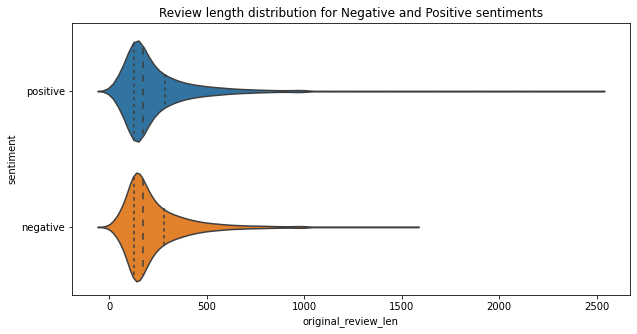

In [13]:
plt.figure(figsize=(10, 5))
sns.violinplot(x = 'original_review_len', y = 'sentiment', data = df, inner="quartile",  bw=.2)
plt.title('Review length distribution for Negative and Positive sentiments')
plt.show();

What is the underlying distribution and do these samples of review lengths come from the same distribution?

Let's perform some tests to check that

Shapiro-Wilk:
(0.7877817749977112, 0.0) (0.7948592305183411, 0.0)

t-test:
Ttest_indResult(statistic=2.2677812903217474, pvalue=0.023346823855078545)

Kolmogorov-Smirnov test: 
Ks_2sampResult(statistic=0.024937779480447897, pvalue=4.0314022354868694e-07)

Q-Q plot to compare distributions



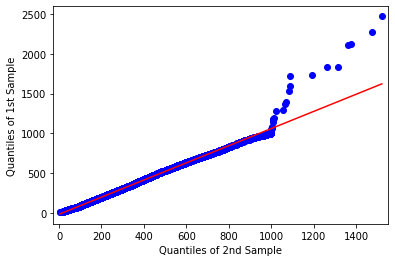

In [14]:
# Hypothesis testing: 
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

# we have two random value samples of review lengths:
rvs1 = df[df.sentiment=='positive'].original_review_len.values
rvs2 = df[df.sentiment=='negative'].original_review_len.values

def run_test_qqplot(rvs1, rvs2):
    # checking if both of these distributions are normal using Shapiro-Wilk
    # read here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
    # H_0: the distribution is normal
    # H-a: the distribution is not normal :)
    shapiro_test1 = stats.shapiro(rvs1)
    shapiro_test2 = stats.shapiro(rvs2)
    print('Shapiro-Wilk:')
    print(shapiro_test1, shapiro_test2)

    # t-test to check if two samples come from the normal distribution with the same mean
    # H_0: the same sample means
    # H-a: sample means are different :)
    print('\nt-test:')
    ttest = stats.ttest_ind(rvs1, rvs2)
    print(ttest)

    # Kolmogorov-Smirnov test to check if these 2 samples come from the same contionious distribution
    # H_0: the samples come from the same distribution
    # H-a: no, they don't :)
    print('\nKolmogorov-Smirnov test: ')
    print(stats.ks_2samp(rvs1, rvs2))

    # Q-Q plot 
    print('\nQ-Q plot to compare distributions\n')
    min_length = min(len(rvs1), len(rvs2))
    pp_x = sm.ProbPlot(rvs1[:min_length])
    pp_y = sm.ProbPlot(rvs2[:min_length])
    qqplot_2samples(pp_x, pp_y, line='r')

run_test_qqplot(rvs1, rvs2)

Conclusions:

1. Shapiro-Wilk: both of review lengths (for positive and negative) come **not** from normal distribution 

2. t-test: even if these samples were normally distributed, their mean values are **not** equal

3. Kolmogorov-Smirnov: underlying distributions are different

4. Q-Q plot: indeed, the underlying distributions are different and not even linearly dependent

In [15]:
nlp.max_length = 1500000
tp = TextPreprocessing(df, 'review')
df['cleaned_review'] = df.apply(lambda row: tp.clean_review(row['review']), axis=1)

In [16]:
df['cleaned_review_len'] = df.apply(lambda row: len(row['cleaned_review'].split()), axis=1)
df.sample(3)

,index,review,sentiment,original_review_len,cleaned_review,cleaned_review_len
27901,28030,For fans of Troma or the Cyberpunk genre mixed...,positive,122,fan troma cyberpunk genre mix little blood she...,59
16061,16106,"""Emma"" was a product of what might be called b...",positive,810,emma product may call first great jane austen ...,442
9356,9371,"If you hit your teens in the 70s, as I did, yo...",negative,523,hit teen probably remember story studio whethe...,259


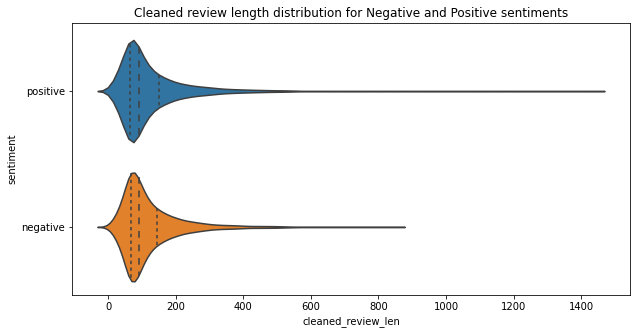

In [17]:
plt.figure(figsize=(10, 5))
sns.violinplot(x = 'cleaned_review_len', y = 'sentiment', data = df, inner="quartile",  bw=.2)
plt.title('Cleaned review length distribution for Negative and Positive sentiments')
plt.show();

Shapiro-Wilk:
(0.7857236862182617, 0.0) (0.7926791310310364, 0.0)

t-test:
Ttest_indResult(statistic=2.82636951636469, pvalue=0.004709775137836945)

Kolmogorov-Smirnov test: 
Ks_2sampResult(statistic=0.029672584020887766, pvalue=6.631067686650717e-10)

Q-Q plot to compare distributions



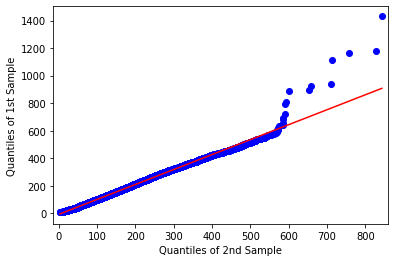

In [18]:
rvs11 = df[df.sentiment=='positive'].cleaned_review_len.values
rvs21 = df[df.sentiment=='negative'].cleaned_review_len.values
run_test_qqplot(rvs11, rvs21)

Again, cleaned reviews lengths for positive and negative sentiments come from different distributions.

### 8. Word Clouds for preprocessed reviews

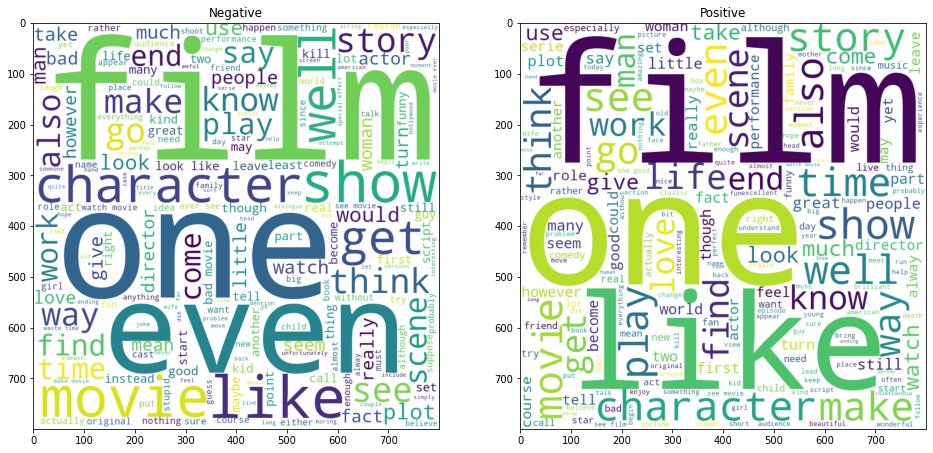

In [19]:
num_clusters = 2

_, axs = plt.subplots(1, 2, figsize=(16, 16))
axs = axs.flatten()

for k, ax in zip(range(num_clusters), axs):
    if k == 0:
        df_pn = df[df.sentiment == 'negative']
        title_pn = 'Negative'
    else:
        df_pn = df[df.sentiment == 'positive']
        title_pn = 'Positive'
    all_words = ' '.join([word.lower() for rev in df_pn.cleaned_review for word in rev.split()])
    ax.imshow(wordcloud(all_words))
    ax.set_title(title_pn)
plt.show()

Nice, we don't see awkward < br br > and we can definetely see different word clouds for positive and negative sentiments (except obvious words like 'one', film', 'show', etc)

### 9. Vocabulary and top popular words

Number of unique lemmas in the corpus: 143137


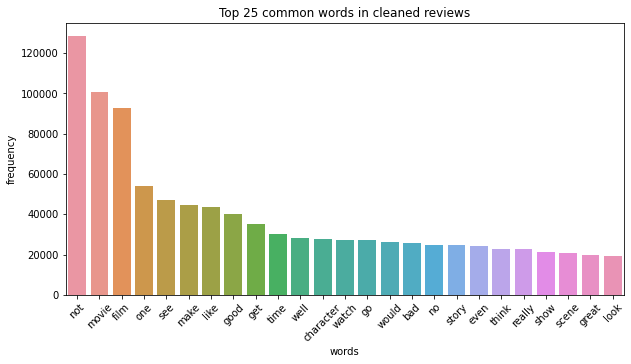

In [20]:
def wordcount_plot_top_common(data, column, number_of_top_common_words=25, title='Top words'):    
    corpus = ' '.join(data[column])
    print(f'Number of unique lemmas in the corpus: {len(set(corpus.split()))}')

    wordcount = {}
    for word in corpus.split():
        word = word.strip()
        if word in wordcount:
            wordcount[word] += 1
        else:
            wordcount[word] = 1

    word_counter = Counter(wordcount)
    lst = word_counter.most_common(number_of_top_common_words)
    top_words = pd.DataFrame(lst, columns = ['Word', 'Count'])
    # plt.figure(figsize=(10, 5))
    sns.barplot(x = 'Word', y='Count', data = top_words)
    plt.xlabel('words')
    plt.xticks(rotation=45)
    plt.ylabel('frequency')
    plt.title(title)
    plt.show();


plt.figure(figsize=(10, 5))
wordcount_plot_top_common(df, 'cleaned_review', title='Top 25 common words in cleaned reviews')

In [21]:
df.to_csv('drive/My Drive/cleaned_imdb.csv')

Positive top-words VS negative top-words

Number of unique lemmas in the corpus: 94381


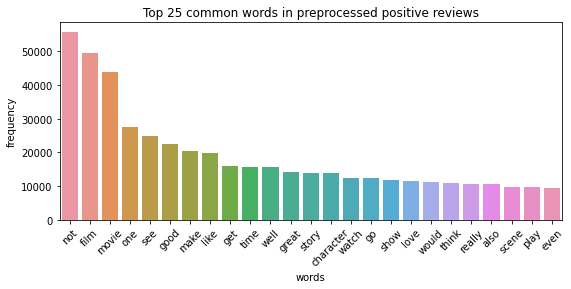

Number of unique lemmas in the corpus: 90117


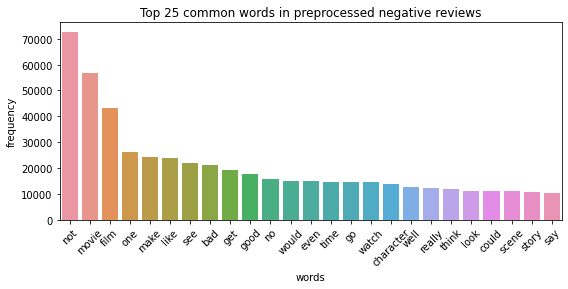

In [22]:
plt.figure(figsize=(9, 8))
plt.subplot(2, 1, 1)
wordcount_plot_top_common(df[df.sentiment=='positive'], 'cleaned_review', title='Top 25 common words in preprocessed positive reviews')
plt.figure(figsize=(9, 8))
plt.subplot(2, 1, 2)
wordcount_plot_top_common(df[df.sentiment=='negative'], 'cleaned_review', title='Top 25 common words in preprocessed negative reviews')

### 10. Tf-Idf and some ML on cleaned reviews data

In [23]:
data = df.copy()
data['target'] = data.sentiment.apply(lambda x: int(x == 'positive'))
data = data.drop(columns = ['sentiment', 'review', 'index'])
data.sample(3)

,original_review_len,cleaned_review,cleaned_review_len,target
1566,287,ne kelly bear later probably would victoria cr...,133,1
30222,311,year old time live salt lake city utah still r...,162,1
6493,134,brit director chrstopher nolan career america ...,74,1


In [24]:
X = data.drop('target', axis=1)
y = data.target
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

train_corpus = x_train.cleaned_review.to_list()
test_corpus = x_test.cleaned_review.to_list()
tf_idf = TfidfVectorizer(max_features=300)
X_train = tf_idf.fit_transform(train_corpus).todense()
X_test = tf_idf.transform(test_corpus).todense()

In [25]:
X_train = np.hstack((X_train, x_train.original_review_len.to_numpy().reshape(-1, 1), x_train.cleaned_review_len.to_numpy().reshape(-1, 1)))
X_test = np.hstack((X_test, x_test.original_review_len.to_numpy().reshape(-1, 1), x_test.cleaned_review_len.to_numpy().reshape(-1, 1)))
print(f'Train data shape: {X_train.shape}, test data shape: {X_test.shape}')

Train data shape: (39665, 302), test data shape: (9917, 302)


In [27]:
def report_classifier(clf, clf_name, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'{clf_name} gets accuracy {accuracy_score(y_test, y_pred)}')
    print(f'\nClassification report: \n{classification_report(y_test, y_pred)}')
    print()
    cm = confusion_matrix(y_test, y_pred)
    cm_xticklabels = ['real positive', 'real negative']
    cm_yticklabels = ['pred. positive', 'pred. negative']
    g = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", linewidths=.5, xticklabels=cm_xticklabels, yticklabels = cm_yticklabels)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
    g.set_xticklabels(g.get_xticklabels(), fontsize = 12)
    plt.title(f'{clf_name} confusion matrix')
    plt.show();
    return y_pred

#### 10.1 Random Forest

Random Forest Classifier gets accuracy 0.7899566401129374

Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      4939
           1       0.78      0.81      0.79      4978

    accuracy                           0.79      9917
   macro avg       0.79      0.79      0.79      9917
weighted avg       0.79      0.79      0.79      9917




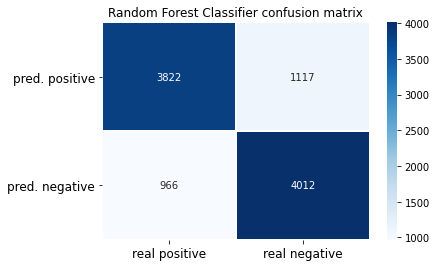

In [28]:
rfc = RandomForestClassifier()

y_pred_rfc = report_classifier(rfc, 'Random Forest Classifier', X_train, y_train, X_test)

#### 10.2 Voting Classifier

Voting Classifier gets accuracy 0.7928809115659978

Classification report: 
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4939
           1       0.79      0.79      0.79      4978

    accuracy                           0.79      9917
   macro avg       0.79      0.79      0.79      9917
weighted avg       0.79      0.79      0.79      9917




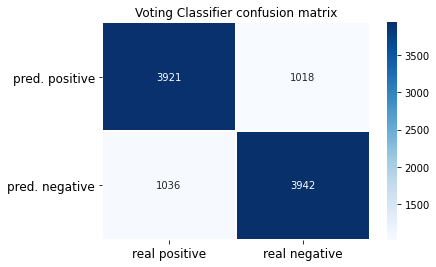

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

clf1 = AdaBoostClassifier(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
vote = VotingClassifier(estimators=[
        ('ada', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard', weights=[1, 2, 1])

y_pred_vote = report_classifier(vote, 'Voting Classifier', X_train, y_train, X_test)

#### 10.3 LightGBM

LightGBM Classifier gets accuracy 0.8042754865382676

Classification report: 
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      4939
           1       0.79      0.83      0.81      4978

    accuracy                           0.80      9917
   macro avg       0.80      0.80      0.80      9917
weighted avg       0.80      0.80      0.80      9917




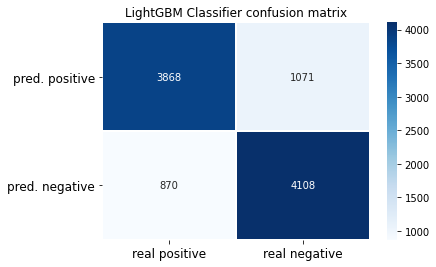

In [31]:
import lightgbm 
lgb = lightgbm.LGBMClassifier()

y_pred_lgb = report_classifier(lgb, 'LightGBM Classifier', X_train, y_train, X_test)

#### 10.4 Evaluating classifiers on a sample review

In [32]:
def try_review_on_clf(clf, test_review='i love it'):    
    len_original = len(test_review.split())
    cleaned_test_review = tp.clean_review(test_review)
    len_cleaned = len(cleaned_test_review.split())
    vectorized_test_review = tf_idf.transform([cleaned_test_review]).todense()
    vectorized_test_review = np.hstack((vectorized_test_review, np.array([len_original]).reshape(-1, 1), np.array([len_cleaned]).reshape(-1, 1)))
    pred = clf.predict(vectorized_test_review)[0]
    prediction = 'positive' if pred == 1 else 'negative'
    return prediction

test_review = 'I hate this movie, i don\'t recommend to anyone watch it. the actors are bad and scenario is poor'
try_review_on_clf(rfc, test_review), try_review_on_clf(vote, test_review), try_review_on_clf(lgb, test_review)

('negative', 'negative', 'negative')

In [33]:
test_review = 'nice film, though boring sometimes and actors are not perfect but in general i recommend to watch it'
try_review_on_clf(rfc, test_review), try_review_on_clf(vote, test_review), try_review_on_clf(lgb, test_review)

('positive', 'positive', 'positive')